In [1]:
import adi
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Parámetros globales
nb_samples = 100
SF = 4
samples_per_symbol = 2**SF
ref = 0.5
# ref = 0.3


In [2]:
# Generar bits random
z = np.random.uniform(size=nb_samples) # numeros random entre 0 y 1

x = [1 if z[i]>ref else 0 for i in range(len(z))] 
txSignal = (2*np.repeat(x, 2**4)-1)+1j*(2*np.repeat(x, 2**4)-1) # Transmitir señal

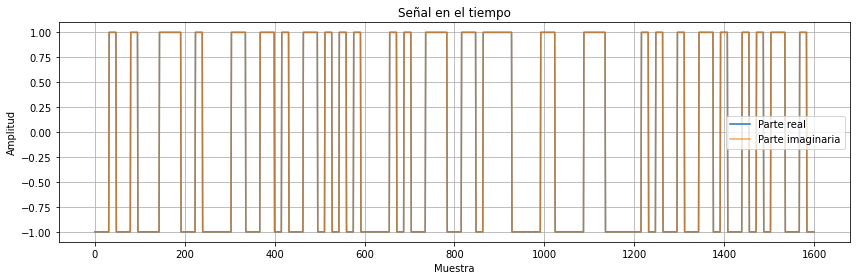

In [3]:
# Grafica temporal
plt.figure(figsize=(12, 4))
plt.plot(np.real(txSignal), label='Parte real')
plt.plot(np.imag(txSignal), label='Parte imaginaria', alpha=0.7)
plt.title('Señal en el tiempo')
plt.xlabel('Muestra')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

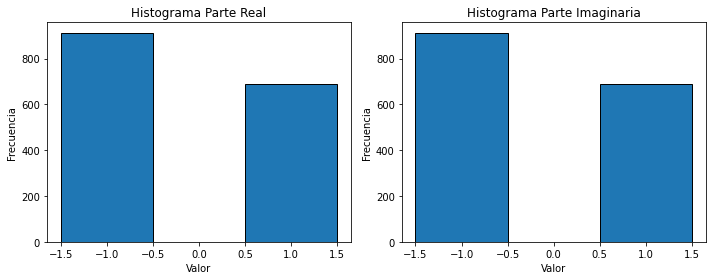

In [4]:
# Histogramas
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(np.real(txSignal), bins=np.arange(-1.5, 2, 1), edgecolor='black')
plt.title('Histograma Parte Real')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
plt.hist(np.imag(txSignal), bins=np.arange(-1.5, 2, 1), edgecolor='black')
plt.title('Histograma Parte Imaginaria')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

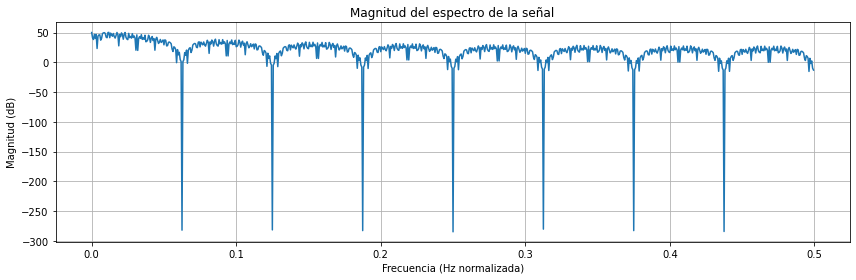

In [5]:
# Grafica de frecuencias
# Transformada de Fourier
N = len(txSignal)
frecuencia = fftfreq(N, d=1)  # Frecuencias
espectro = fft(txSignal)

plt.figure(figsize=(12, 4))
plt.plot(np.abs(frecuencia[:N // 2]), 20*np.log10(np.abs(espectro[:N // 2])))
plt.title('Magnitud del espectro de la señal')
plt.xlabel('Frecuencia (Hz normalizada)')
plt.ylabel('Magnitud (dB)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Configuración del SDR
Uri = "ip:192.168.1.34"
SamplingRate = int(10e6)
Loopback = 0

# Tx:
TxLOFreq = int(938e6)
TxAtten = -79  # cambiar a -70 en punto 3
TxRfBw = int(10e6)
tx_cyclic_buffer = True

# Rx:
RxLOFreq = TxLOFreq
GainControlModes = "manual"
RxHardwareGain = 70
RxRfBw = TxRfBw
RxBufferSize = 2**18 

# Asignación a SDR
sdr = adi.Pluto(Uri)
sdr.sample_rate = SamplingRate
sdr.loopback = Loopback

sdr.tx_lo = TxLOFreq
sdr.tx_hardwaregain_chan0 = TxAtten
sdr.tx_rf_bandwidth = TxRfBw
sdr.tx_cyclic_buffer = tx_cyclic_buffer

sdr.rx_lo = RxLOFreq
sdr.gain_control_mode_chan0 = GainControlModes
sdr.rx_hardwaregain_chan0 = RxHardwareGain
sdr.rx_rf_bandwidth = RxRfBw
sdr.rx_buffer_size = RxBufferSize

In [7]:
# Transmision t recepcion
# Cargar y transmitir la señal
sdr.tx(txSignal * (2**14))  # Transmisión
print("Transmisión iniciada...")

# Limpieza del buffer de recepción  
for i in range(0, 10):
    raw_data = sdr.rx()

# Recepción
rxSignal = sdr.rx()
print("Recepción completa.")

# Normalización a potencia unitaria
rxSignal /= np.sqrt(np.mean(np.abs(rxSignal)**2))

# Cierre del dispositivo
sdr.tx_destroy_buffer()  # Libera el buffer de transmisión

Transmisión iniciada...
Recepción completa.


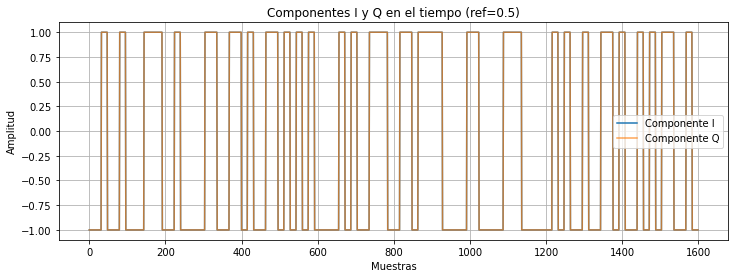

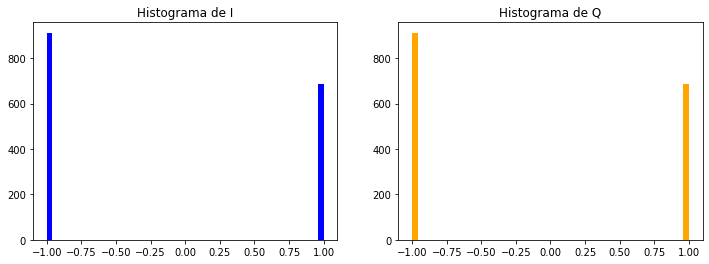

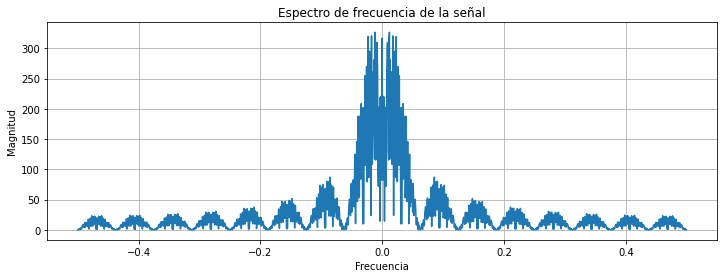

In [8]:
# Analisis temporal, espectral e histograma

I = np.real(txSignal)
Q = np.imag(txSignal)

# Temporal
plt.figure(figsize=(12, 4))
plt.plot(I, label='Componente I')
plt.plot(Q, label='Componente Q', alpha=0.7)
plt.title("Componentes I y Q en el tiempo (ref=0.5)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend()
plt.grid()
plt.show()

# Histogramas
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.hist(I, bins=50, color='blue')
plt.title("Histograma de I")
plt.subplot(1,2,2)
plt.hist(Q, bins=50, color='orange')
plt.title("Histograma de Q")
plt.show()

# Espectro
from scipy.fft import fft, fftfreq
N = len(txSignal)
T = 1.0
yf = fft(txSignal)
xf = fftfreq(N, T)

plt.figure(figsize=(12,4))
plt.plot(np.fft.fftshift(xf), np.fft.fftshift(np.abs(yf)))
plt.title("Espectro de frecuencia de la señal")
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.grid()
plt.show()


In [9]:
# Transmicion, limpieza del buffer y recepcion 

sdr.tx(txSignal * (2**14))

for _ in range(10):
    _ = sdr.rx()

rxSignal = sdr.rx()
rxSignal = rxSignal / np.sqrt(np.mean(np.abs(rxSignal)**2))  # Normalización


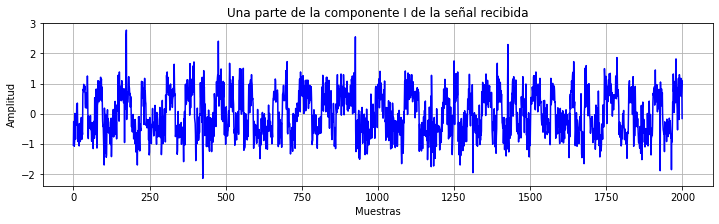

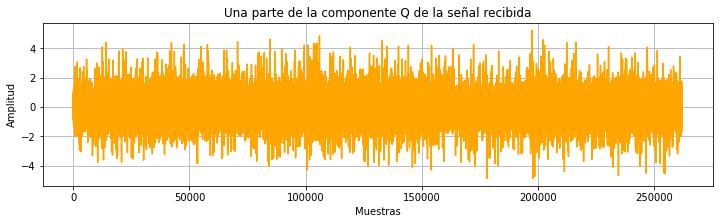

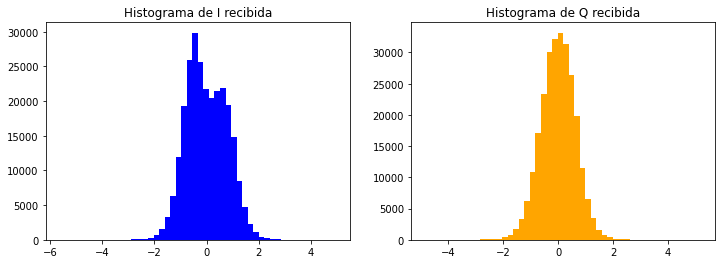

In [10]:
# Graficos de la señal recibida
I_rx = np.real(rxSignal)
Q_rx = np.imag(rxSignal)
N=2000

# Gráfico de la componente I
plt.figure(figsize=(12, 3))
plt.plot(I_rx[:N], color='blue')
plt.title("Una parte de la componente I de la señal recibida")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

# Gráfico de la componente Q
plt.figure(figsize=(12, 3))
plt.plot(Q_rx, color='orange')
plt.title("Una parte de la componente Q de la señal recibida")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()
plt.show()


# Histogramas
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(I_rx, bins=50, color="blue")
plt.title("Histograma de I recibida")
plt.subplot(1, 2, 2)
plt.hist(Q_rx, bins=50, color="orange")
plt.title("Histograma de Q recibida")
plt.show()


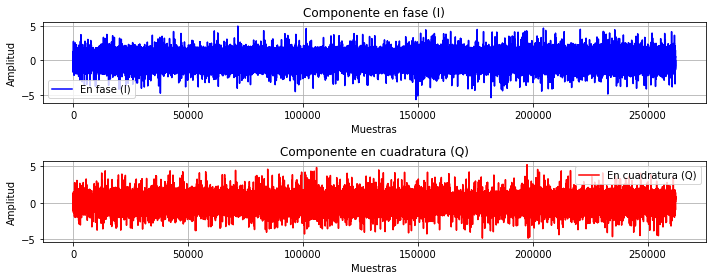

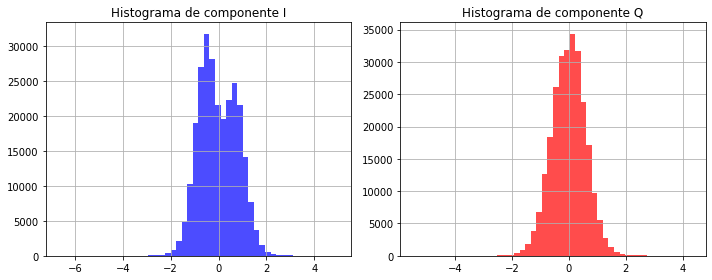

In [12]:
# Parte 2
sdr.tx_hardwaregain = -70               # Atenuación en TX [dB]

sdr.tx_destroy_buffer()
sdr.tx(txSignal * (2**14))

for i in range(0, 10):
    raw_data = sdr.rx()

rxSignal2 = sdr.rx()
rxSignal2 /= np.sqrt(np.mean(np.abs(rxSignal2)**2))
sdr.tx_destroy_buffer()

plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.plot(np.real(rxSignal), label="En fase (I)", color='blue')
plt.title("Componente en fase (I)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.imag(rxSignal), label="En cuadratura (Q)", color='red')
plt.title("Componente en cuadratura (Q)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(np.real(rxSignal2), bins=50, color='blue', alpha=0.7)
plt.title("Histograma de componente I")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(np.imag(rxSignal2), bins=50, color='red', alpha=0.7)
plt.title("Histograma de componente Q")
plt.grid(True)

plt.tight_layout()
plt.show()

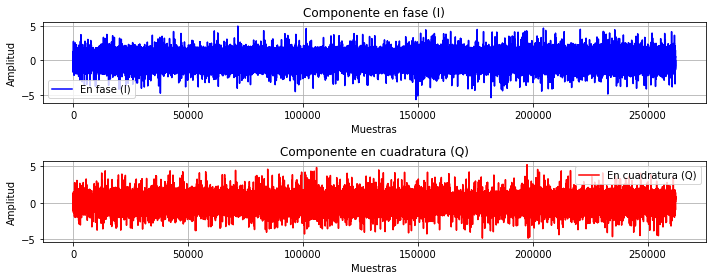

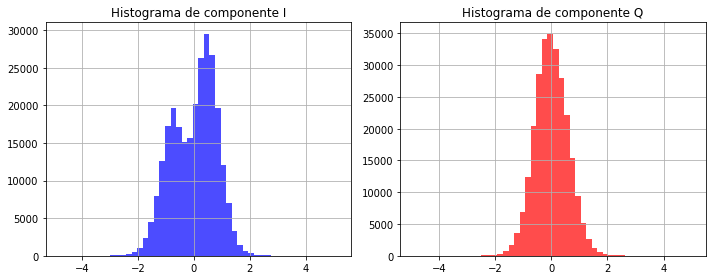

In [13]:
# Transmision con probabilidades a priori distintas
ref = 0.3

z = np.random.uniform(size=nb_samples)
x = [1 if z[i]>ref else 0 for i in range(len(z))] 
txSignal3 = (2*np.repeat(x, 2**4)-1)+1j*(2*np.repeat(x, 2**4)-1) 

sdr.tx_hardwaregain = -79

sdr.tx(txSignal3 * (2**14))

for i in range(0, 10):
    raw_data = sdr.rx()

rxSignal3 = sdr.rx()
rxSignal3 /= np.sqrt(np.mean(np.abs(rxSignal3)**2))
sdr.tx_destroy_buffer()

plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.plot(np.real(rxSignal), label="En fase (I)", color='blue')
plt.title("Componente en fase (I)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.imag(rxSignal), label="En cuadratura (Q)", color='red')
plt.title("Componente en cuadratura (Q)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(np.real(rxSignal3), bins=50, color='blue', alpha=0.7)
plt.title("Histograma de componente I")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(np.imag(rxSignal3), bins=50, color='red', alpha=0.7)
plt.title("Histograma de componente Q")
plt.grid(True)

plt.tight_layout()
plt.show()

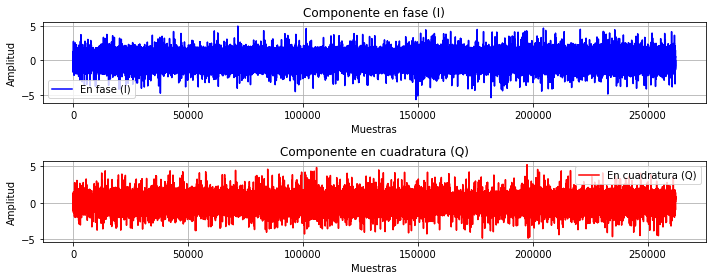

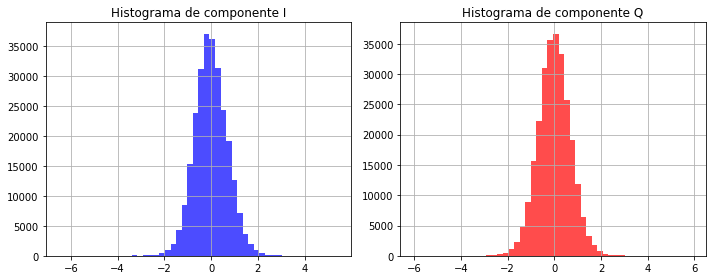

In [14]:
# Transmision de señal no binaria
x = np.array([-1, -0.3333, 0.3333, 1])
nb_samples = 10

I = np.random.choice(x, nb_samples, p=[0.25, 0.25, 0.25, 0.25])  # Generar parte real aleatoria con igual probabilidad
Q = np.random.choice(x, nb_samples, p=[0.25, 0.25, 0.25, 0.25])  # Generar parte imaginaria aleatoria con igual probabilidad

txSignal4 = I + 1j*Q  # Señal transmitida

sdr.tx(txSignal4 * (2**14))

for i in range(0, 10):
    raw_data = sdr.rx()

rxSignal4 = sdr.rx()
rxSignal4 /= np.sqrt(np.mean(np.abs(rxSignal4)**2))
sdr.tx_destroy_buffer()

plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.plot(np.real(rxSignal), label="En fase (I)", color='blue')
plt.title("Componente en fase (I)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.imag(rxSignal), label="En cuadratura (Q)", color='red')
plt.title("Componente en cuadratura (Q)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(np.real(rxSignal4), bins=50, color='blue', alpha=0.7)
plt.title("Histograma de componente I")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(np.imag(rxSignal4), bins=50, color='red', alpha=0.7)
plt.title("Histograma de componente Q")
plt.grid(True)

plt.tight_layout()
plt.show()


En las graficas temporales de la señal recibida es posible ver que ahora la señal no llega a valer 0 si no un valor cercano (-0.3333 y +0.3333) en cada cambio de valor trasnmitido. Hay presencia de ruido pero aun puede distinguirse claramente los niveles.

Respecto a los histogramas, ahora no tenemos dos picos pronunciados en -1 y +1, sino cuatro ubicados aproximadamente en -1, -0.3333, 0.3333 y 1. La altura de los picos es similar, indicando que los simbolos tienen igual probabilidad. La forma de cada pico sigue una distribucion tipo gaussiana debido al ruido aditivo.